# Connectivity

*Structural* connectivity: direct neuronal connectivity

*functional* connectivity: How brain regions temporally co-vary with each other in time. Not necessarily imply that two regions are directly communicate with each other. Usually means *undirected* graphs.

*effective* connecitivity: directed graphs or *causal models*.

## Functional connectivity

### See voxel correlations

A simple way to quantify func connectivity: compute the temporal correlation between two regions of interest (ROIs). Typically, this is done by extracting the temporal response from a *seed voxel* or the average response within a *seed region*. Then, this time course is regressed against all other voxels in the brain to produce a whole brain map of anywhere stat share a similar time course to the seed.

Let's try it out with an example subject from RepDopa study. First, let's import the modules we need for this.

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy

import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
from bids import BIDSLayout, BIDSValidator
import nibabel as nib

data_dir = '/home/hcp4715/Data/RepDopa/Nipy/BIDS'
layout = BIDSLayout(data_dir, derivatives=True)

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sub = '001'
sess = 'd1'
fwhm = 6

data = Brain_Data(layout.get(subject=sub, session=sess, task='exp', 
                             scope='derivatives', suffix='bold', 
                             extension='nii.gz', return_type='file')[1])
smoothed=data.smooth(fwhm=fwhm)

Next, we need to pick a ROI. Pretty much any type of ROI will work.

In this example, we will use a whole brain parcellation based on similar pattern of coactivation across over 10, 000 published studies available in neurosynthm. We will be using a parcellation of 50 different functionally similar ROIs

threshold is ignored for simple axial plots


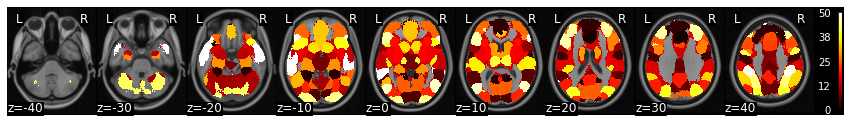

In [3]:
#mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')
mask = Brain_Data(os.path.join('.', 'ROI_masks', 'k50_2mm.nii.gz'))
mask.plot()

Each ROI in this parcellation has its own unique number. We can expand this so that each ROI becomes its own binary mask using `nltools.mask.expand_mask`.

Let's plot the first 5 masks.

threshold is ignored for simple axial plots


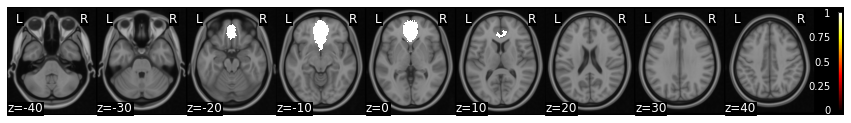

In [4]:
mask_x = expand_mask(mask)

f = mask_x[32].plot()

To use any mask, we just need to index it by the correct label.

Let's start by using the vmPFC mask (ROI=32) as a seed in a functional connectivity analaysis.


Text(0.5, 0, 'Time (TRS)')

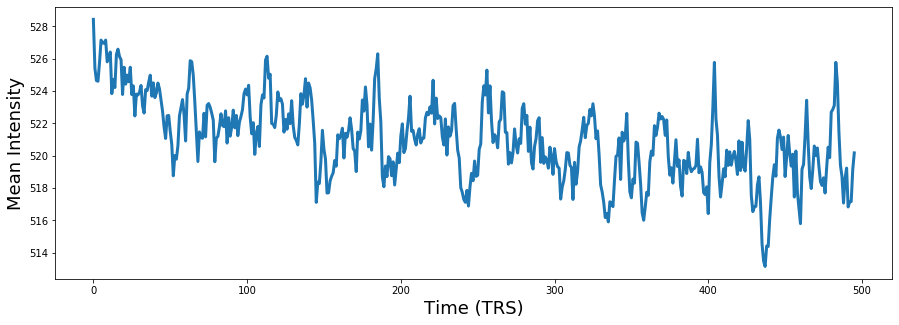

In [5]:
vmpfc = smoothed.extract_roi(mask=mask_x[32])

plt.figure(figsize=(15,5))
plt.plot(vmpfc, linewidth=3)
plt.ylabel('Mean Intensity', fontsize=18)
plt.xlabel('Time (TRS)', fontsize=18)

Now, let's buid our regression design matrix to perform the whole-brain functional connectivity analysis.


The goal is to find which regions in the brain have a similar time course to the vmPFC, controlling for all our covariates (i.e., nuisance regressors).

Functional connectivity analyses are particularly sensitive to artifacts that might induce a temporal relationship, particularly head motion. This means that we will need to use slightly different steps to preprocess data for this type of analysis than a typical event related mass univariate analysis.

We are going to remove the mean from our vmPFC signal. We are also going to include the average activity in CSF as an additional nuisance regressor to remove physiological artifacts. Finally, we will include 24 motion covariates as well as linear and quadratic trends. We need to be a little careful about filtering as the normal high pass filter for an event related design might be too short and will remove potential signal of interest.

Resting state researchers also remove the global signal, which can reduce physiological and motion related artifacts and also increase the likelihood of observing negative relationship with seed region. This procedure has remained quite controversial in practice. We (Luke Cheng) think that in general including co-variate like CSF should be sufficient. 

It is also common to additionally include covariate from white matter masks, and also, multiple principal components of this signal rather than just the mean.

Overall, this code should seem very familiar as it is pretty much the same procedure we used in the single subject GLM tutorial. However, instead of modeling the task design, we are interested in calculating the functional connecitivity with the vmPFC.

threshold is ignored for simple axial plots


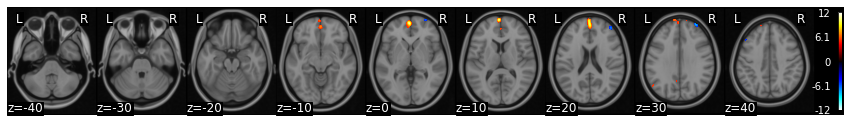

In [6]:
tr = layout.get_tr()
fwhm = 6
n_tr = len(data)

def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    
    return Design_Matrix(all_mc, sampling_freq=1/tr)

vmpfc = zscore(pd.DataFrame(vmpfc, columns=['vmpfc']))

csf_mask = Brain_Data(layout.get(subject=sub, label='CSF', 
                             scope='derivatives', suffix='probseg', 
                             extension='nii.gz', return_type='file')[1])

csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf'])) 

spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)

covariates = pd.read_csv(layout.get(subject='001', session='d1', scope='derivatives', extension='.tsv')[0].path, sep='\t')

mc = covariates[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr)

dm = Design_Matrix(pd.concat([vmpfc, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)
# dm.heatmap(cmap='RdBu_r', vmin=-1, vmax=1)

smoothed.X = dm

stats = smoothed.regress()

vmpfc_conn = stats['beta'][0]

vmpfc_conn.threshold(upper=5, lower=-5).plot()

For an actual analysis, we would need to repeate this procedure over all of the participants in our sample and then perform a second level group analysis to identify which voxels are consistently co-active with the vmPFC. 

## Psychophysiological Interactions

Suppose we are interested in seeing if the vmPFC was connected to other regions differently at the onset of CS+ compared with other conditions (CS-). To compuate this, we will need to create a new design matrix that combines the CS+ regressors and then calculate an interaction term between the seed region activity (e.g., vmPFC) and the condition of interest (e.g., CS+).

This type of analysis is called *psychophysiological* interactions was originally proposed by Friston et al., 1997. 

In [7]:
def recode_trial_type(trial_type):
    """ recode trial type based on needs
    Here, we hope to have a simple contrast for CS+ vs. CS-, therefore we pool all CS- and CS+ (with/without US)
    """
    if trial_type == 'CSplT' or trial_type == 'CSplF':
        return 'CSpl'
    elif trial_type == 'CSminT' or trial_type == 'CSminF':
        return 'CSmin'
    elif trial_type == 'RateCSmin' or trial_type == 'RateCSpl':
        return 'rating'
    elif trial_type == 'ContextOff' or trial_type == 'ContextOn':
        return 'context'

# define a function create design_matrix from BIDS event file

def load_bids_events(layout, subject, session):
    '''
    Create a design_matrix instance from BIDS events file.
    Note: the number of TR is same as the length of preprocessed data by fmriprep
    '''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, 
                               session=session,
                               scope='raw',
                               suffix='bold')[1].path).shape[-1] # Get number of TRs
    onsets = pd.read_csv(layout.get(subject=subject,
                                    session=session,
                                    scope='raw',
                                    suffix='events')[0].path, 
                         sep = '\t')
    onsets.onset = (onsets.onset - onsets.onset[0])/1000
    
    # Get the number of pulses (TRs)
    onsets['cumcount'] = onsets.groupby('trial_type').cumcount()
    # onsets.head()
    pulsenum = onsets[(onsets['trial_type'] == 'Pulse')]
    maxpulse = pulsenum['cumcount'].max()
    pulsenum.head()
    maxpulse

    cutoff_idx = onsets[(onsets['trial_type'] == 'Pulse') & (onsets['cumcount'] == maxpulse)].index.tolist()[0]
    # cutoff_idx


    onsets = onsets.truncate(before=0, after=cutoff_idx)
    
    #onsets = onsets[(onsets['onset']>0)]

    onsets['trial_type'] = onsets['trial_type'].apply(recode_trial_type)
    onsets = onsets[(onsets['trial_type'].notnull())]
    
    onsets = onsets.drop(['ratings', 'cumcount', 'duration'], axis=1)

    onsets.rename(columns={'onset': 'Onset', 
     #              'duration': 'Duration',
                   'trial_type': 'Stim'}, inplace=True)
    
    return onsets_to_dm(onsets, sampling_freq = 1/tr, run_length=n_tr)

In [8]:
onsets = pd.read_csv(layout.get(subject=sub,
                                session=sess,
                                scope='raw',
                                suffix='events')[0].path, 
                     sep = '\t')
onsets.onset = (onsets.onset - onsets.onset[0])/1000

# Get the number of pulses (TRs)
onsets['cumcount'] = onsets.groupby('trial_type').cumcount()
# onsets.head()
pulsenum = onsets[(onsets['trial_type'] == 'Pulse')]
maxpulse = pulsenum['cumcount'].max()
pulsenum.head()
maxpulse

cutoff_idx = onsets[(onsets['trial_type'] == 'Pulse') & (onsets['cumcount'] == maxpulse)].index.tolist()[0]
# cutoff_idx


onsets = onsets.truncate(before=0, after=cutoff_idx)

#onsets = onsets[(onsets['onset']>0)]

onsets['trial_type'] = onsets['trial_type'].apply(recode_trial_type)
onsets = onsets[(onsets['trial_type'].notnull())]
onsets = onsets.drop(['ratings', 'cumcount', 'duration'], axis=1)
onsets.head(10)

onset trial_type
13    11.030     rating
20    16.447     rating
30    23.514    context
36    28.530       CSpl
62    52.046      CSmin
86    74.562      CSmin
113   99.079       CSpl
136  120.595       CSpl
165  144.161      CSmin
189  166.677      CSmin

In [9]:
dm = load_bids_events(layout, sub, sess)

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nltools/file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  "Only 2 columns in file, assuming all stimuli are the same duration"


In [10]:
dm.head()

rating  context  CSpl  CSmin
0     0.0      0.0   0.0    0.0
1     0.0      0.0   0.0    0.0
2     0.0      0.0   0.0    0.0
3     0.0      0.0   0.0    0.0
4     0.0      0.0   0.0    0.0

In [11]:
cs_variables = ['CSpl', 'CSmin']
ppi_dm = dm.drop(cs_variables, axis=1)
ppi_dm['cs'] = pd.Series(dm.loc[:, cs_variables].sum(axis=1))
ppi_dm_conv = ppi_dm.convolve()
ppi_dm_conv['vmpfc'] = vmpfc
ppi_dm_conv['vmpfc_cs'] = ppi_dm_conv['vmpfc']*ppi_dm_conv['cs_c0']

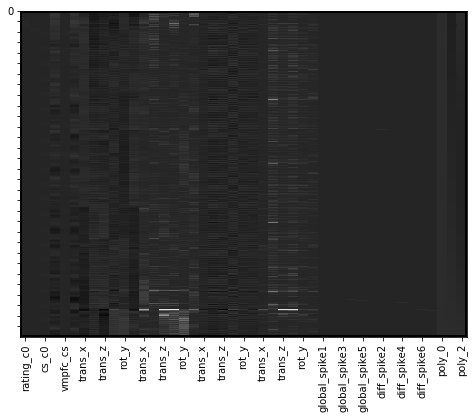

In [12]:
dm = Design_Matrix(pd.concat([ppi_dm_conv, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)
dm.heatmap()

Okey, now we are ready to run the regression analysis and inspect the interaction term to find regions where the connectivity profile changes as as function of the CS task.

We will run regression and smooth all the images, and then examine the beta images for the PPI interaction term.

threshold is ignored for simple axial plots


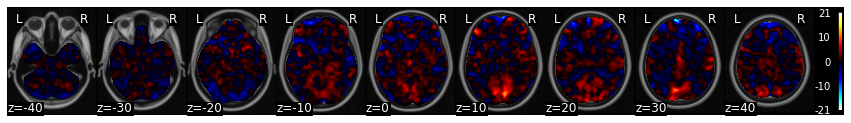

In [13]:
smoothed.X = dm
ppi_stats = smoothed.regress()

vmpfc_cs_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='vmpfc_cs')[0][0])]
f = vmpfc_cs_ppi.plot()

We can make a thresholded interactive plot to interrogate these results

In [14]:
vmpfc_cs_ppi.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Dynamic connectivity

## Effective connectivity

### Structural Equation Modeling

### Granger Causality

### Dynamic Causal Modeling


## Multivariate Decomposition

*Multivariate decomposition* methods attempt to factorize a data set into a lower dimensional set of components, where each has their own unique time course.

The most common decomposition methods are Principal Components Analysis (PCA) and Independent Components Analysis (ICA). 


### PCA

PCA tries to explain the variance-coriance structure of a high dimensional random vector. In this procedure, a set of correlated variables are transformed into a set of uncorrelated variables, ordered by the amount of variance in the data that they explain.

In fMRI, we use PCA to find spatial maps or *eigenimages* in the data. This is usually computed using Singular Value Decomposition (SVD). This operation is defined as: $ X = USV^{T}$, where $V^{T}V= I$, $U^{T}U= I$, and $S$ is a diagonal matrix whose elements are called singular values.

In practice, $V$ corresponds to the eigenimages or spatial components and $U$ corresponds to the transformation matrix to convert the eigenimages into a timecourse. $S$ reflects the amount of scaling for each component.


SVD is conceptually very similar to regression. We are trying to explain a matrix $X$ as a linear combination of components. Each term in the equation reflects a unique (i.e., orthogonal) multivariate signal present in $X$. For example, the $nth$ signal in $X$ can be described by the dot product of a time course $u_{n}$ and the spatial map $Vn^{T}$ scaled by $s_{n}$.

$$X = s_{1}u_{1}v_{1}^{T} + s_{2}u_{2}v_{2}^{T} + ... + s_{n}u_{n}v_{n}^{T}$$

Let's try running a PCA on our single subject data.


First, let's denoise our data using a GLM comprised only of nuisance regressors. We will then work with the *residual* of this model, or what remains of our data that was not explained by the denoising model. This is essentially identical to the vmPFC analysis, except that we will not be including any seed regressors. We will then work with the residual of our regression, which is the remaining signal after removing any variance associated with our covariates.

In [15]:
csf_mask = csf_mask = Brain_Data(layout.get(subject=sub, label='CSF', 
                             scope='derivatives', suffix='probseg', 
                             extension='nii.gz', return_type='file')[1])

csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf'])) 

spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)

covariates = pd.read_csv(layout.get(subject='001', session='d1', scope='derivatives', extension='.tsv')[0].path, sep='\t')

mc = covariates[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr)

dm = Design_Matrix(pd.concat([vmpfc, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)
# dm.heatmap(cmap='RdBu_r', vmin=-1, vmax=1)

smoothed.X = dm

stats = smoothed.regress()

smoothed_denoised=stats['residual']

Now, let's run a PCA on this participant's denoised data. To do this, we will use the `.decompose()` method from `nltools`. All we need to do is specify the algorithm we want to use, the dimension we want to reduce (i.e., time - 'images' or space 'voxels'), and the number of components to estimate. Usually, we will be looking at reducing space based on similarity in time, so we will set `axis='image'`.

In [16]:
n_components = 10

pca_stats_output = smoothed_denoised.decompose(algorithm='pca', axis='images',
                                              n_components=n_components)

Now, let's inspect the components with our interactive component viewer. Remember the ICA tutorial? Hopefully, you are now better able to understand everything.

In [17]:
component_viewer(pca_stats_output, tr=layout.get_tr())

interactive(children=(BoundedIntText(value=0, description='Component', max=9), BoundedFloatText(value=2.0, des…

We can also examine the eigenimage/singular values or scaling factor of each, which are the diagonals of $S$.

These valuesare stored in the `decomposition_object` of the stat_output and are in the variable called `.singular_values_`.

Text(0, 0.5, 'Singular Values')

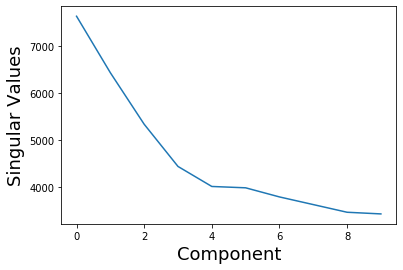

In [18]:
plt.plot(pca_stats_output['decomposition_object'].singular_values_)
plt.xlabel('Component', fontsize=18)
plt.ylabel('Singular Values', fontsize=18)

We can use these values to calculate the overall variance explained by each component. These values are stored in the `decomposition_object` of the `stats_output`and are in the variable called `.explained_variance_ration_`.

These values can be used to create what is called a *scree* plot to figure out the percent variance of $X$ explained by each component. Remeber, in PCA, components are ordered by descending variance explained.

Text(0.5, 1.0, 'Cumulative Varience_explained')

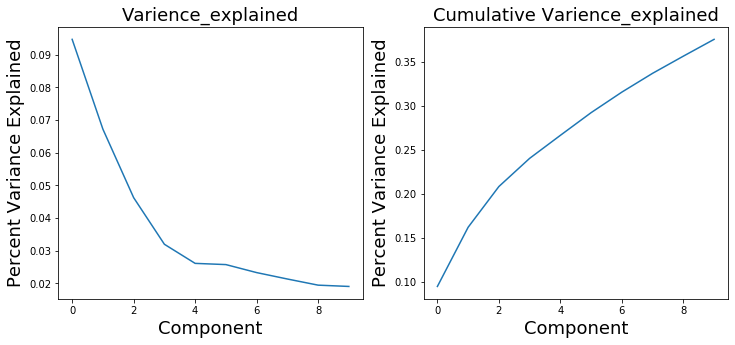

In [20]:
f, a = plt.subplots(ncols=2, figsize=(12, 5))
a[0].plot(pca_stats_output['decomposition_object'].explained_variance_ratio_)
a[0].set_ylabel('Percent Variance Explained', fontsize=18)
a[0].set_xlabel('Component', fontsize=18)
a[0].set_title('Varience_explained', fontsize=18)
a[1].plot(np.cumsum(pca_stats_output['decomposition_object'].explained_variance_ratio_))
a[1].set_ylabel('Percent Variance Explained', fontsize=18)
a[1].set_xlabel('Component', fontsize=18)
a[1].set_title('Cumulative Varience_explained', fontsize=18)